In [1]:
from cellpose.models import Cellpose
from cellpose import plot
import numpy as np
from skimage.measure import regionprops
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2
from shapely.geometry import Point, Polygon
from scipy.interpolate import splprep, splev
from scipy.spatial.distance import cdist
from shapely.geometry import LineString
from shapely.geometry import MultiPoint
from scipy.spatial.distance import euclidean
from scipy.spatial import distance

In [2]:
# for cytoplasm
dropbox = "/Users/nicholb/Dropbox"
folder = f"{dropbox}/Anqi/Intership/AI_segmentation/python_segmentation/Limb_Ext_Stg01"
stack = np.array(imread(f"{folder}/Stg01_Emb02_Lb01.tif"))
layer = 10
img = stack[layer, :, :, 3]
pmad = stack[layer, :, :, 2]
model = Cellpose(gpu=True, model_type='cyto')
masks, flows, styles, diams = model.eval(img, diameter=30, channels=[0,0])

In [3]:
cell = np.where(masks==50, img, 0)
np.mean(img[masks==50])
pmad_cells = []
props = regionprops(masks)
centroids = np.array([prop.centroid for prop in props])

for i in range(1, masks.max()+1):
    pmad_cells.append(np.mean(pmad[masks==i]))


(-0.5, 450.5, 251.5, -0.5)

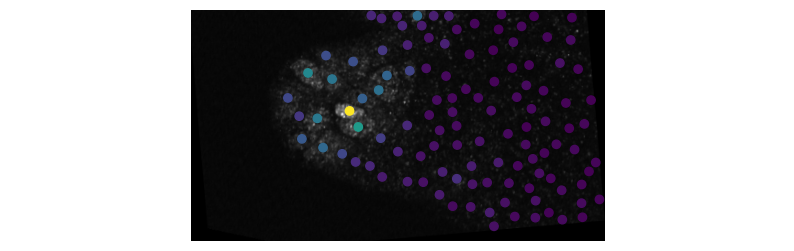

In [4]:
fig, ax = plt.subplots()
fig.set_size_inches(10,3)
ax.imshow(pmad, cmap="gray")
ax.scatter(centroids[:,1],centroids[:,0],c=pmad_cells)
ax.axis('equal')    
ax.axis("off")

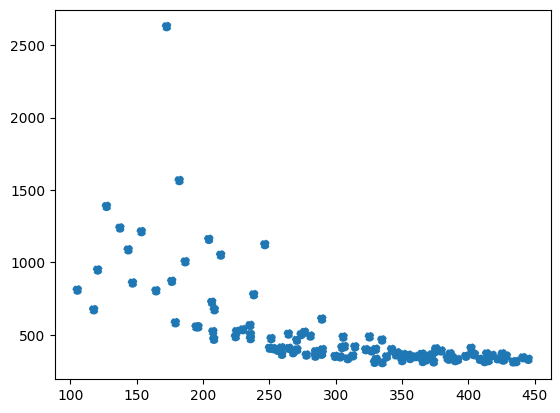

In [8]:
plt.scatter(centroids[:,1], pmad_cells, marker='o', linestyle='--')

In [10]:
csv_filename = 'TdEmbryo_Hoechst_pMad488_dpp546_brk647_20240506_LimbExtension10-Ant_Contour.csv'
roi_points_array = np.loadtxt(csv_filename, delimiter=',')
roi_points_array = np.array([roi_points_array[:,1],roi_points_array[:,0]]).T
# print("ROI points loaded successfully:")
# print(roi_points_array)

# Convert roi_points_array to a Shapely Polygon
roi_polygon = Polygon(roi_points_array)

# Filter centroids that lie within the contour
centroids_within_contour = []
pmad_cells_within_contour = []

for centroid, pmad_cell in zip(centroids, pmad_cells):
    # Create a Shapely Point object for the centroid
    centroid_point = Point(centroid)
    # Check if the centroid lies within the contour polygon
    if roi_polygon.contains(centroid_point):
        centroids_within_contour.append(centroid)
        pmad_cells_within_contour.append(pmad_cell)

# Convert centroids_within_contour to a NumPy array
centroids_within_contour_array = np.array(centroids_within_contour)
pmad_cells_within_contour_array = np.array(pmad_cells_within_contour)


FileNotFoundError: TdEmbryo_Hoechst_pMad488_dpp546_brk647_20240506_LimbExtension10-Ant_Contour.csv not found.

In [11]:
csv_filename2 = 'TdEmbryo_Hoechst_pMad488_dpp546_brk647_20240506_LimbExtension10-Ant_Spline.csv'
spline_points_array = np.loadtxt(csv_filename2, delimiter=',')
spline_points_array = np.array([spline_points_array[:,1],spline_points_array[:,0]]).T

tck, _ = splprep(spline_points_array.T, s=0)
n_points = 1000
t_values = np.linspace(0, 1, n_points)
spline_points = np.array(splev(t_values, tck))
closest_spline_points = []
distances = cdist(centroids_within_contour_array, spline_points.T)
closest_point_indices = np.argmin(distances, axis=1)
closest_spline_points = spline_points[:, closest_point_indices]
distal_cell_index = closest_point_indices.min()

spline_dist = np.zeros(n_points)
for i in range(1, n_points):
    increment = np.linalg.norm(spline_points[:, i]-spline_points[:, i-1])
    spline_dist[i] = spline_dist[i-1] + increment

spline_dist -= spline_dist[distal_cell_index]
print("Closest spline points to centroids within contour:")
plt.imshow(img)
plt.plot(spline_points[1,:],spline_points[0,:])
plt.scatter(spline_points[1, 71], spline_points[0,71])
pixel_to_mu = 1/2.8906
centroid_dists = np.array([spline_dist[i] for i in closest_point_indices])
centroid_dists_mu = centroid_dists * pixel_to_mu

FileNotFoundError: TdEmbryo_Hoechst_pMad488_dpp546_brk647_20240506_LimbExtension10-Ant_Spline.csv not found.

<ErrorbarContainer object of 3 artists>

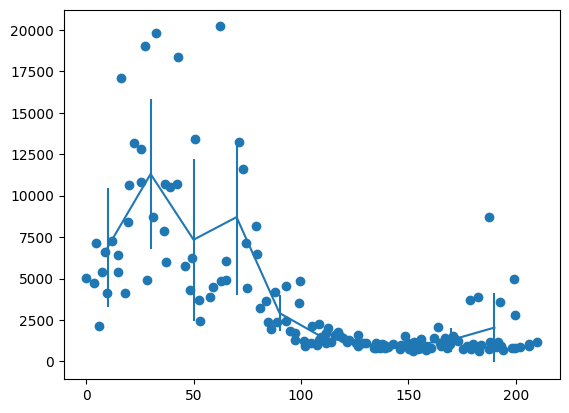

In [429]:

bin_size = 20 
bins = np.arange(np.min(centroid_dists_mu), np.max(centroid_dists_mu), bin_size)
bin_centers = (bins[:-1] + bins[1:])/2
n_bins = len(bins)
pmad_binned = np.zeros(n_bins-1)
pmad_err_binned = np.zeros(n_bins-1)
for i in range(1, n_bins):
    indices = np.where(np.logical_and(centroid_dists_mu>bins[i-1],centroid_dists_mu<bins[i]))[0]
    pmad_in_bin = [pmad_cells_within_contour[j] for j in indices]
    pmad_binned[i-1] = np.mean(pmad_in_bin)
    pmad_err_binned[i-1] = np.std(pmad_in_bin)
plt.scatter(centroid_dists_mu, pmad_cells_within_contour_array)
plt.errorbar(bin_centers, pmad_binned, yerr=pmad_err_binned)

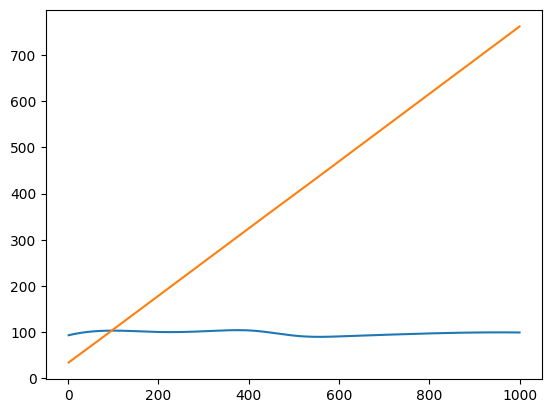

In [268]:
X_axis = range(1, 1001)
x = spline_points[0, :]
y = spline_points[1, :]

plt.plot(X_axis, x)
plt.plot(X_axis, y)
plt.show()

In [305]:
gs = np.argmin(closest_point_indices)
closest_point_indices



array([664, 620, 516, 487, 500, 534, 719, 778, 513, 555, 612, 463, 688,
       750, 179, 439, 199, 150, 279, 411, 367, 722, 813, 136, 300, 859,
       238, 521, 650, 173, 266, 792, 214, 106, 496, 621, 329, 601, 455,
       552, 833, 755, 512, 581, 688, 626, 649, 473, 797, 861, 422, 130,
       673, 605,  89, 737, 360, 829, 697, 712, 319, 241, 783, 271, 496,
       736, 217, 635, 101, 665, 184, 586, 455, 530, 772, 869,  71, 318,
       403, 605, 143, 353, 813, 484, 839, 572, 901, 724, 386, 682, 418,
       472, 621, 119, 649, 779, 446, 499, 173,  86, 110, 219, 747, 815,
       194, 860, 129, 605, 886, 329, 706, 544, 795, 148, 253, 675, 504,
       741, 383, 826, 764, 567, 855,  95, 365, 406, 160, 226, 262, 616,
       886, 305, 439, 791, 281, 391, 465, 835, 657, 571, 697, 539, 731])

In [301]:
# Assuming closest_spline_points is your ndarray

# Access the second row (y-values) of the ndarray
y_values = closest_spline_points[1, :]

# Find the index of the minimum y-value
min_y_index = np.argmin(y_values)

# Extract the coordinates of the point with the smallest y-value
point_distal = closest_spline_points[:, min_y_index]

# Print the point with the smallest y-value
print("Point with the smallest y-value:", point_distal)

Point with the smallest y-value: [102.41387713  85.24276814]


In [234]:
def spline_distance_to_point(spline_points_array, point_distal, closest_spline_points, num_samples=1000):
    # Interpolate the spline curve
    tck, u = splprep(spline_points_array.T, s=0)
    
    # Sample points along the spline curve
    u_new = np.linspace(0, 1, num_samples)
    spline_points = np.array(splev(u_new, tck)).T
    
    # Find the closest point on the spline to point_distal
    closest_point_distal_index = np.argmin(distance.cdist([point_distal], spline_points))
    closest_point_distal = spline_points[closest_point_distal_index]
    
    # Calculate the distance from point_distal to the closest point on the spline
    distances_to_point_distal = np.linalg.norm(point_distal - closest_point_distal)
    
    # Calculate the distances between all points in closest_spline_points to point_distal
    distances_to_point_distal_traversing_spline = []
    for point in closest_spline_points:
        # Find the closest point on the spline to the current point
        closest_point_index = np.argmin(distance.cdist([point], spline_points))
        closest_point = spline_points[closest_point_index]
        
        # Calculate the distance from the current point to the closest point on the spline
        distance_to_spline = np.linalg.norm(point - closest_point)
        
        # Total distance from point_distal to the current point traversing the spline
        # total_distance = distances_to_point_distal + distance_to_spline
        total_distance = distances_to_point_distal + distance_to_spline
        distances_to_point_distal_traversing_spline.append(total_distance)
    
    return distances_to_point_distal_traversing_spline

# arr = closest_spline_points
# arr_transposed = arr.T
distances_to_point_distal_traversing_spline = spline_distance_to_point(spline_points_array, point_distal, centroids_within_contour_array)
print("Distances between all points in closest_spline_points to point_distal traversing the spline:")
print(distances_to_point_distal_traversing_spline)

Distances between all points in closest_spline_points to point_distal traversing the spline:
[75.59515442784902, 75.09995442685309, 72.82541792965868, 61.489964709961214, 65.8260927263277, 56.56459618180237, 67.03950893853653, 62.095771383494764, 55.841835481863185, 51.97648283523577, 52.88689684465158, 58.90528864970566, 51.59370935661711, 51.15736834101488, 58.89016030602219, 55.319766671122736, 47.88264584272896, 53.30830869009357, 50.80286371428759, 51.57575583299863, 48.77329997793725, 43.706951068650966, 48.94528752094567, 44.23973883256209, 41.77529576146316, 44.29746068303263, 37.59558401712551, 40.81036104140284, 37.662171861071364, 35.903522815537336, 37.6257408113457, 38.27347123518279, 34.28261639288144, 42.782969941252105, 36.905602718191076, 34.01097409218136, 40.4988523240324, 28.291817627382045, 24.223056741833037, 16.17293791000405, 29.61535775091685, 26.482389184107642, 18.16564096695705, 16.203526819117535, 20.530370112153282, 16.32229739336361, 14.780941063770847, 1

In [241]:
spline_points_array

array([[ 93.,  34.],
       [103., 103.],
       [100., 181.],
       [102., 259.],
       [103., 331.],
       [ 91., 407.],
       [ 91., 481.],
       [ 95., 567.],
       [ 98., 648.],
       [ 99., 762.]])

In [236]:
centroids_within_contour_array

array([[ 17.54567308, 521.11538462],
       [ 16.51118211, 488.64696486],
       [ 18.52838428, 402.62882096],
       [ 33.32513661, 377.80874317],
       [ 27.35616438, 388.45205479],
       [ 33.61518987, 419.85063291],
       [ 27.88414634, 560.12195122],
       [ 34.60080645, 603.05241935],
       [ 35.74413146, 401.19014085],
       [ 37.80815348, 437.66426859],
       [ 38.42786683, 481.78051788],
       [ 39.11156187, 360.21501014],
       [ 42.31627907, 537.11162791],
       [ 44.77346683, 582.37046308],
       [ 42.16260163, 160.80487805],
       [ 45.76376147, 344.16284404],
       [ 52.5186846 , 177.1838565 ],
       [ 48.81039755, 140.04281346],
       [ 50.4068323 , 239.66459627],
       [ 51.78424015, 327.92120075],
       [ 55.57918051, 302.24916944],
       [ 51.4137931 , 561.44334975],
       [ 48.75956284, 627.80327869],
       [ 58.48442907, 130.25432526],
       [ 60.21879815, 254.47919877],
       [ 54.31602709, 660.97065463],
       [ 62.68760908, 207.4904014 ],
 

In [170]:
# # Initialize a list to store the distances
# distances_along_spline = []

# # Evaluate the spline at each point in closest_spline_points and calculate the distance to smallest_x_point
# for point in closest_spline_points:
#     # Calculate the Euclidean distance between the current point and smallest_x_point
#     distance = euclidean((point[0], point[1]), (smallest_x_point.x, smallest_x_point.y))
    
#     # Append the distance to the list
#     distances_along_spline.append(distance)

# print("Distances along the spline to smallest_x_point:")
# print(distances_along_spline)

Distances along the spline to smallest_x_point:
[26.714099148354904, 591.6157184745929]


In [186]:
# type = type(closest_spline_points).__name__
# print("Type :", type)
closest_spline_points.shape
# print(closest_spline_points)

(2, 143)

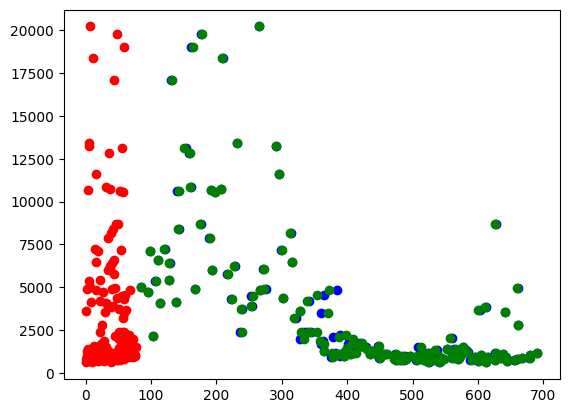

In [235]:
plt.scatter(centroids_within_contour_array[:, 1], pmad_cells_within_contour_array, color='blue', marker='o')
plt.scatter(closest_spline_points[1, :], pmad_cells_within_contour_array, color='green', marker='o')
# plt.scatter(distances_to_point_distal_traversing_spline, pmad_cells_within_contour_array, color='red', marker='o')


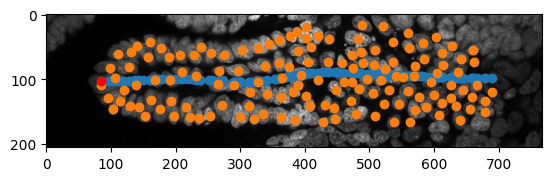

In [244]:
plt.imshow(img, cmap='gray')
plt.scatter(closest_spline_points[1,:],closest_spline_points[0,:])
plt.scatter(centroids_within_contour_array[:,1],centroids_within_contour_array[:,0])
plt.plot(point_distal[1], point_distal[0], 'ro', label='Intersection Point')

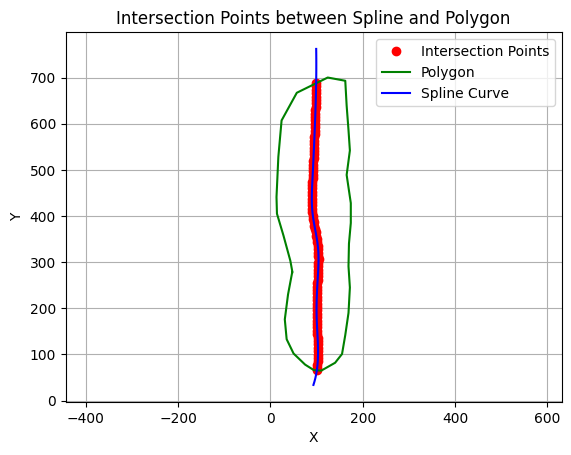

In [145]:
# Extract the coordinates from the LineString object
intersection_coords = np.array(intersection_points.xy).T

# Plot the intersection points
plt.plot(intersection_coords[:, 0], intersection_coords[:, 1], 'ro', label='Intersection Points')

# Plot the original polygon
plt.plot(*roi_polygon.exterior.xy, 'g-', label='Polygon')

# Plot the spline curve
plt.plot(*spline_line.xy, 'b-', label='Spline Curve')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Intersection Points between Spline and Polygon')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


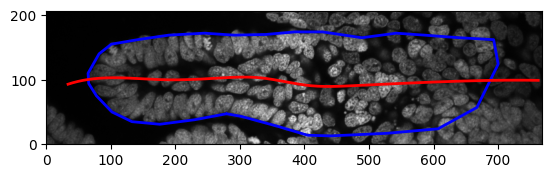

In [133]:
knot_points = tck[0]
spline_coefficients = tck[1]
degree = tck[2]

t_values = np.linspace(0, 1, 1000)

# Evaluate the spline at the specified parameter values
spline_points = np.array(splev(t_values, tck))

# Plot the original image
plt.imshow(img, cmap='gray')

plt.plot(roi_points_array[:, 1], roi_points_array[:, 0], color='blue', linewidth=2)
# Plot the spline curve on top of the image
plt.plot(spline_points[1], spline_points[0], color='red', linewidth=2)

# Set axis limits to match the image dimensions
plt.xlim(0, img.shape[1])
plt.ylim(0, img.shape[0])  # Note: Y-axis is flipped in images

# Show the plot
plt.show()

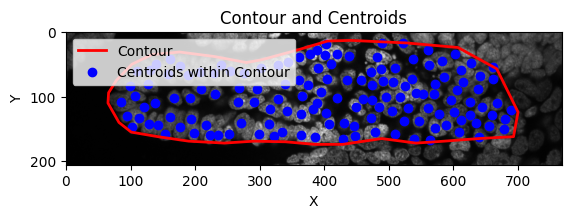

In [45]:

# Plot the original image
plt.imshow(img, cmap='gray')

# Plot the contour (polygon)
plt.plot(roi_points_array[:, 1], roi_points_array[:, 0], color='red', linewidth=2)

# Plot the centroids within the contour
plt.scatter(centroids_within_contour_array[:, 1], centroids_within_contour_array[:, 0], color='blue', marker='o')
# plt.scatter(centroids_within_contour_array[:, 0], centroids_within_contour_array[:, 1], color='blue', marker='o')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Contour and Centroids')
plt.legend(['Contour', 'Centroids within Contour'])

# Show the plot
plt.show()

In [ ]:
from hcrp.segmentation import segment
from skimage import io
dropbox = "/Users/nicholb/Dropbox"
folder = f"{dropbox}/Anqi/Intership/AI_segmentation/python_segmentation/Limb_Ext_Stg01"
segment(f"{folder}/Stg01_Emb02_Lb01", f"../data/Limb_Ext_Stg01")
# stack = io.imread(f"{folder}/Stg01_Emb02_Lb01.tif")
# image = stack[10, :, :, 3]
# channels = [0, 0]
# model = Cellpose(gpu=True, model_type="cyto")
# masks, flows, styles, diams = model.eval(image, diameter=30, channels=channels)
# props = regionprops(masks)


: 

In [6]:
n_colors = len(np.unique(masks))
random_colour_map = np.random.rand(n_colors,3)
cmap = LinearSegmentedColormap.from_list(name="random", colors=random_colour_map)
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.imshow(img)
ax.imshow(masks, cmap=cmap, alpha=0.2)


Error in callback <function _draw_all_if_interactive at 0x3634c5790> (for post_execute), with arguments args (),kwargs {}:


ValueError: data mapping points must start with x=0 and end with x=1

ValueError: data mapping points must start with x=0 and end with x=1

<Figure size 1000x500 with 1 Axes>

In [ ]:
np.save('media/masks.npy', masks)